## Binome G6:
- Florent MACAIRE
- Abdoulkader MOUSSA MOHAMED

# Privacy project

In [1]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import requests
import math
import sys
import os
import time
import statistics
from statistics import mean 
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
# Open source library for binarytree a little bit modified for our need
current_dir = os.getcwd()
project_dir = os.path.join(current_dir, 'Project')
from mybinarytree.binarytree import *

# Load dataset

In [2]:
url = "https://zenodo.org/record/5509268/files/buses.parquet"
response = requests.get(url)
open("buses.parquet", "wb").write(response.content)

table = pq.read_table("buses.parquet")
df = table.to_pandas()

print(df)

            departure_time          stop_name route_short_name  direction_id  \
0      2021-09-06 05:15:00   Maison d'Accueil               C6             0   
1      2021-09-06 05:15:00       Clos Courtel               C4             0   
2      2021-09-06 05:15:00       Clos Courtel               C4             0   
3      2021-09-06 05:15:00   Maison d'Accueil               C6             0   
4      2021-09-06 05:15:00     Bourgchevreuil               C6             0   
...                    ...                ...              ...           ...   
690447 2021-12-12 23:45:00  Beaulieu Restau U               C4             1   
690448 2021-12-12 23:45:00            Le Mail               C4             0   
690449 2021-12-12 23:45:00        Tournebride               C4             1   
690450 2021-12-12 23:45:00  Beaulieu Restau U               C4             1   
690451 2021-12-12 23:45:00    Beaulieu Chimie               C4             1   

        stop_id  count   stop_lat  stop

# Functions for Binarytree

In [3]:
def recursive_wavelet_transform(node, lambda_coeff, tree_depth):
    """
    Compute recursively the value of the nodes corresponding to Haar Wavelet Transform (HWT) 
    and add noise following the laplace distribution.

    Return the sum of the values of its leaves. 

    Node must be a complete tree.
    """
    
    # Case: node is a leaf  
    if node.left == None and node.right == None:
        return node.value  
    
    # Recursive calls  
    left_sum = recursive_wavelet_transform(node.left, lambda_coeff, tree_depth)
    right_sum = recursive_wavelet_transform(node.right, lambda_coeff, tree_depth)

    height = node.height

    # Number of leaves in the each branch of the current node
    number_leaves_left = 2**(height - 1)
    
    # Computing the node value
    node.value = ((left_sum / number_leaves_left) - (right_sum / number_leaves_left)) / 2    
    
    # Add noise 
    node.value += np.random.laplace(0, lambda_coeff/(pow(2, tree_depth - (tree_depth - height + 1) + 1)))
    
    return left_sum + right_sum


def HWT_convert(l, lambda_coeff):
    """
    Convert a list of integers to a Binarytree which follows the Haar Wavelet Transform(HWT) 
    and to which Laplace noise has been added with magnitude lambda_coeff/ W_Haar(c). 

    Return a Binarytree and the base coeff (like the Fig.2 with noise)
    """
    # Create a BinaryTree  
    size_arr = len(l)
    depth_tree = math.ceil(math.log(size_arr, 2))
    my_tree = tree(depth_tree - 1, True) #make a perfect tree of depth "depth_tree"

    # Create and inserting the leaves with values from l
    level_order_index_l = 2**depth_tree - 1 #level order at which to start placing nodes from l
    for node in l:
        my_tree[level_order_index_l] = Node(node)
        level_order_index_l = level_order_index_l + 1

    # Complete the remaining leaves with 0 to have 2**depth_tree leaves
    for i in range(2**depth_tree - size_arr):
        my_tree[level_order_index_l] = Node(0)
        level_order_index_l = level_order_index_l + 1
    
    # Compute each node of the BinaryTree 
    base_coeff = recursive_wavelet_transform(my_tree, lambda_coeff, depth_tree) / pow(2, depth_tree)
    
    # Add noise to the base coefficient
    base_coeff += np.random.laplace(0, lambda_coeff/pow(2, depth_tree))
            
    return (my_tree, base_coeff)

def recursive_hwt_to_list(hwt_tree, base_coeff, ancestor_sum, transformed_data):
    """
    Take a BinaryTree and then convert it back to a list recursively.
    
    base_coeff: the base coefficient of the original BinaryTree
    ancestor_sum: sum of ancestor values depending on the position of the Node
    transformed_data: results are added to it
    """
    
    # Case Node is a leaf: c_0 + sum(g_i * c_i) (formula number 3 from the paper)
    if hwt_tree.left is None and hwt_tree.right is None:
        transformed_data.append(base_coeff + ancestor_sum)
        return 
    
    recursive_hwt_to_list(hwt_tree.left, base_coeff, ancestor_sum + hwt_tree.value, transformed_data)
    recursive_hwt_to_list(hwt_tree.right, base_coeff, ancestor_sum - hwt_tree.value, transformed_data)
    return 

def HWT_with_noise_to_list(hwt_tree, base_coeff, data_len):
    """
    Take a BinaryTree to which Laplace noise has been added and convert it back to a list.
    
    base_coeff: the base coefficient of the BinaryTree
    data_len: Original length of the data list
    """
    
    transformed_data = []
    recursive_hwt_to_list(hwt_tree, base_coeff, 0, transformed_data)
    
    return transformed_data[:data_len]

In [4]:
def group_by_N_element(l, n):
    """
    [a, b, c, d, e, f] with n=2 --> [a + b, c + d, e + f]
    """
    result = []
    index = 0
    
    for i in range(math.floor(len(l) / n)): 
        
        elements_sum = 0

        for j in range(n):
            elements_sum += l[index+j]

        result.append(elements_sum)
        index += n;
    
    return result

def convertDataToAFrequencyMatrix(table, stop_name):
    """
    Take a data table and then convert it to a matrix.
    Return a list of count for each departure_time
    """
    
    bus_stop_data = df[df['stop_name'] == stop_name] # Keep onmy the data one bus stop 
    timestamp_counts = bus_stop_data.groupby('departure_time').size() # Group by those data by departure_time

    timestamp_count_list = timestamp_counts.to_list() # Count for each departure_time
        
    return timestamp_count_list

In [5]:
def compute_mean_squarred_error(l, epsilons, N):
    relative_errors_privelet = []
    relative_errors_naive = []
    
    l_compressed = group_by_N_element(l, N)
    
    for epsilon in epsilons:
        relative_error_privelet = []
        relative_error_naive = []
        
        lambda_coeff = 2*(1 + math.log(len(l), 2)) / epsilon
        for i in range(1):
            (tree_hwt, base_coeff) = HWT_convert(l, lambda_coeff)
            data_with_privelet = HWT_with_noise_to_list(tree_hwt, base_coeff, len(l))
            data_with_privelet = group_by_N_element(data_with_privelet, N)
            
            relative_error_privelet.append(mean_squared_error(l_compressed, data_with_privelet))   

        for i in range(1):

            data_naive = [ element + np.random.laplace(0, 1/epsilon)  for element in l]
            data_naive = group_by_N_element(data_naive, N)
            
            relative_error_naive.append(mean_squared_error(l_compressed, data_naive))
            
        relative_errors_privelet.append(mean(relative_error_privelet))
        relative_errors_naive.append(mean(relative_error_naive))
        
    return (relative_errors_privelet, relative_errors_naive)
 

def plot(ordered_axis, privelet_data, naive_data):
    plt.plot(ordered_axis, privelet_data, label='Privelet', color='blue')
    plt.plot(ordered_axis, naive_data, label='Naive', color='red')
    plt.xlabel('Epsilons')
    plt.ylabel('Counts')
    plt.legend(loc='best');    

## Test on paper example

In [6]:
lambda_coeff = 1

l = [9, 3, 6, 2, 8, 4, 5, 7]
(tree_test, base_coeff) = HWT_convert(l, lambda_coeff)
result_privelet = HWT_with_noise_to_list(tree_test, base_coeff, len(l))

print("index] original_data[index] vs privelet_data[index]\n")
for i in range(len(l)):
    print("{}] {} vs {}".format(i, l[i], result_privelet[i]))


index] original_data[index] vs privelet_data[index]

0] 9 vs 10.034656783674283
1] 3 vs 1.3326320323558347
2] 6 vs 5.789624975295217
3] 2 vs 2.0968931040365666
4] 8 vs 7.915697470375866
5] 4 vs 5.13162457930574
6] 5 vs 5.782451004929204
7] 7 vs 6.300982293346334


## Test on real data

In [7]:
def check_is_well_converted_to_binarytree(tree, l):
    """
    Check that the conversion from list l to BinaryTree is OK.
    """
    height = tree.height
    
    # Compute the sum of the first height power of 2
    level_order_index = 0
    for i in range(0, height):
        level_order_index += 2**i
    
    # Check that leaves have the correct value compared to l       
    for i in range(len(l)):
        leaf_value = tree[level_order_index + i].value
        assert l[i] == leaf_value
    
    # Check that the dummy leaves are equal to 0 as expected
    for i in range(len(l), 2**height):
        assert tree[level_order_index + i].value == 0
    
    print("--- SUCCEED --- ")
    return 
    

In [8]:
check_is_well_converted_to_binarytree(tree_test, l)

--- SUCCEED --- 


# Measure on real data

## Mean Squared Error

In [9]:
epsilons = [0.01, 0.1, 1] 

frequency_departure_time = 120 # in minute
bus_stop_name = 'Beaulieu Restau U'
l = convertDataToAFrequencyMatrix(table, bus_stop_name)
    
(relative_errors_privelet, relative_errors_naive) = compute_mean_squarred_error(l, epsilons, round(frequency_departure_time / 15))

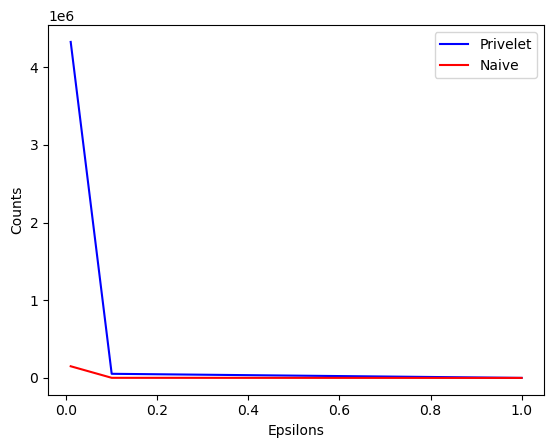

In [10]:
plot(epsilons, relative_errors_privelet, relative_errors_naive)

## Standart deviation

In [11]:
print("Standart deviation on:  privelet -> {} ||  naive data -> {} ".format(statistics.stdev(relative_errors_privelet), statistics.stdev(relative_errors_naive)))  

Standart deviation on:  privelet -> 2480967.3918436654 ||  naive data -> 86261.68828382285 


# Measure on paper data

## Mean Squared Error

In [12]:
epsilons = [0.01, 0.1, 0.5, 0.75, 1, 1.25] 

l = [9, 3, 6, 2, 8, 4, 5, 7]
(relative_errors_privelet, relative_errors_naive) = compute_mean_squarred_error(l, epsilons, 2)

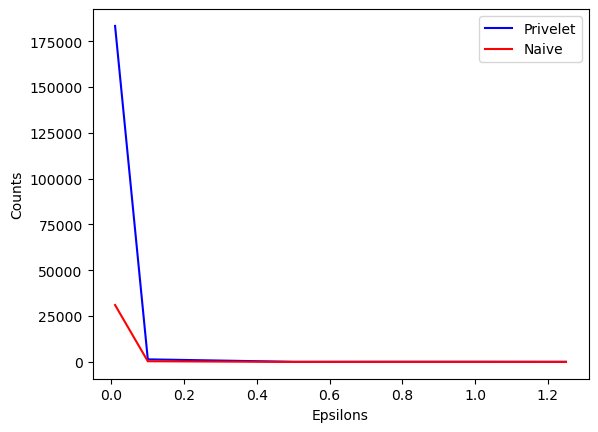

In [13]:
plot(epsilons, relative_errors_privelet, relative_errors_naive)

## Standart deviation

In [14]:
print("Standart deviation on:  privelet -> {} ||  naive data -> {} ".format(statistics.stdev(relative_errors_privelet), statistics.stdev(relative_errors_naive)))  

Standart deviation on:  privelet -> 74692.22754281225 ||  naive data -> 12646.543201146897 


# Original data vs Pertubated data

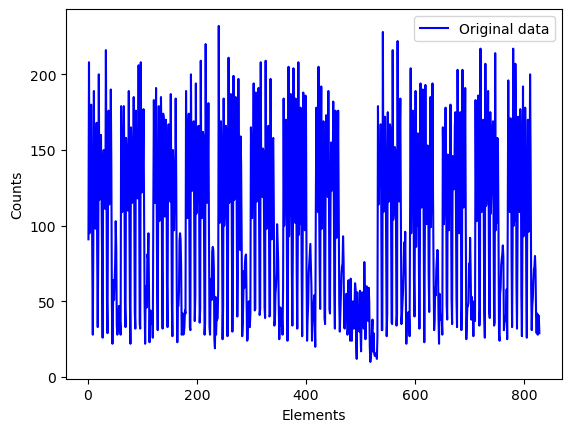

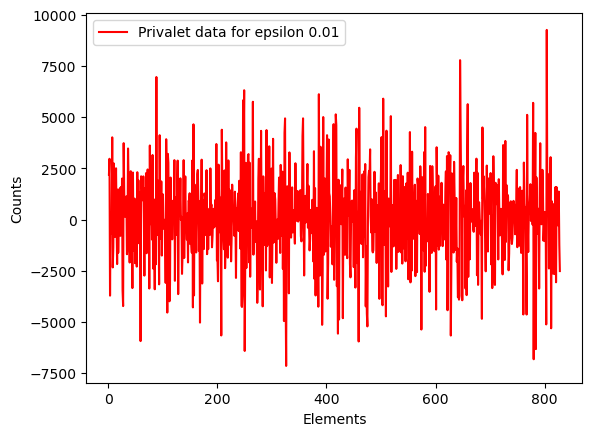

In [15]:
bus_stop_name = 'Beaulieu Restau U'
frequency_departure_time = 120 # in minute

epsilon = 0.01

original_data = convertDataToAFrequencyMatrix(table, bus_stop_name)

# Privelet transform
lambda_coeff = 2*(1 + math.log(len(original_data), 2)) / epsilon
(tree_hwt, base_coeff) = HWT_convert(original_data, lambda_coeff)
data_with_privelet = HWT_with_noise_to_list(tree_hwt, base_coeff, len(original_data))

# Group by departure time: each 60 min, 120 min ...
data_with_privelet = group_by_N_element(data_with_privelet, round(frequency_departure_time / 15))
original_data = group_by_N_element(original_data, round(frequency_departure_time / 15))

horizontal_axis = [i for i in range(1, len(original_data) + 1)]

# Plot the original data
plt.plot(horizontal_axis, original_data, label='Original data', color='blue')
plt.xlabel('Elements')
plt.ylabel('Counts')
plt.legend(loc='best'); 
plt.show()

# Plot the perturbated data
plt.plot(horizontal_axis, data_with_privelet, label='Privalet data for epsilon ' + str(epsilon) , color='red')
plt.xlabel('Elements')
plt.ylabel('Counts')
plt.legend(loc='best'); 
plt.show()


# PS: The 2 plots have not the same axis ticks.

# Computation time

In [16]:
bus_stop_name = 'Beaulieu Restau U'
frequency_departure_time = 120 # in minute

epsilon = 1

original_data = convertDataToAFrequencyMatrix(table, bus_stop_name)

time_privelet = [] # Computation time for privelet transformation
time_naive = [] # Computation time for naive

for i in range(5):
    
    # Measuring computation time for privelet
    time_start = time.perf_counter()
    
    lambda_coeff = 2*(1 + math.log(len(original_data), 2)) / epsilon
    (tree_hwt, base_coeff) = HWT_convert(original_data, lambda_coeff)
    data_with_privelet = HWT_with_noise_to_list(tree_hwt, base_coeff, len(original_data))
    
    time_elapsed = (time.perf_counter() - time_start)
    time_privelet.append(time_elapsed)
    
    # Measuring computation time for naive implementation    
    time_start = time.perf_counter()
    
    data_naive = [ element + np.random.laplace(0, 1/epsilon)  for element in original_data]
    
    time_elapsed = (time.perf_counter() - time_start)
    time_naive.append(time_elapsed)

print("Average computation time:\nPrivelet: {}s \nNaive: {}s".format(mean(time_privelet), mean(time_naive)))    

Average computation time:
Privelet: 12.654699899400294s 
Naive: 0.02505071699852124s


# Explanation

## Mean Squared Error

+ We can observe for both the privelet and naive implementations on real and paper data that the mean squared error(MSE) for the privelet implementation is much larger than the the naive implementation. 
+ We also observe that as epsilon increases, the MSE for the privelet implementation decreases and approaches the one of naive implementation.



## Computation time

We observe that the computation time for the privelet implementation is much larger than the naive implementation. 

This is normal because the privelet implementation:
+ converts the matrix into a tree structure, where the leaves are the data.
+ Based on the values of leaves, the values of ancestors are computed, 
+ and then noise is added to all nodes by traversing the entire tree. 
+ After that, the tree is converted back into a matrix by traversing the tree again. 

For a matrix of length 6000, we have a large binary tree without forgetting that additional dummy values are added to make the length of the tree equal to a power of 2.


## Original data vs Pertubed data

As the value of epsilon increases, the perturbed data becomes progressively closer to the original data.

## Why do we have a big noise on the privelet implementation?

+ For a naive implementation, on an element Y, we only add noise x so it becomes Y+x.
+ For a privelet implementation, a Y element is the sum of it ancestors in the Tree. Adding noise on all his ancestors can explain the difference got on the 2 implementations. 

For a matrix of length 6000, the binary tree in the Privelet implementation has a depth of 13. For a given leaf node Y, its perturbed value can be expressed as the sum of the values of its ancestors, on which noise has been added. Therefore, we have Y_perturbed = $\sum_{i=1}^{13} t_i + x_i$, where $t_i$ represents the value of the ancestor and $x_i$ represents the added noise on it. 

In the Privelet implementation, the perturbed value of Y is equal to $\sum_{i=1}^{13} t_i + x_i$, while in the naive implementation, it is equal to Y + x. This explains the difference got on the 2 implementations. 

## Our opinion

In our implementation, we observed that the results and performance were not the same as in the paper. It is possible that we did not measure the same aspects or variables.

However, based on our implementation, we found that the naive implementation is better than the privelet implementation. The naive implementation provides accurate results for the queries, which makes the results useful, and it also have an excellent computation time.